<a href="https://colab.research.google.com/github/safeai-snu/Econometrics/blob/main/Ch3.3.ARIMA_errors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.3.1. SARIMAX

## 계절성을 포함한 ARIMA 오차 회귀 모델을 통한 일별 전력 소비량 추정

### 1) 모듈과 데이터 불러오기

In [1]:
#모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [2]:
#데이터 불러오기
vic_elec = pd.read_csv("https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.4/vic_elec.csv")

vic_elec['Time'] = pd.to_datetime(vic_elec['Time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
vic_elec['Date'] = vic_elec['Time'].dt.date

vic_elec = vic_elec[(pd.to_datetime(vic_elec['Date']).dt.year == 2013) | (pd.to_datetime(vic_elec['Date']).dt.year == 2014)]

#일별 데이터로의 전처리
vic_elec_daily = vic_elec.groupby('Date').agg({
    'Demand': lambda x: x.sum() / 1e3,
    'Temperature': 'max',
    'Holiday': 'any'
}).reset_index()

vic_elec_daily['Day_Type'] = np.where(
    vic_elec_daily['Holiday'], 'Holiday',
    np.where(pd.to_datetime(vic_elec_daily['Date']).dt.weekday.isin([0, 1, 2, 3, 4]), 'Weekday', 'Weekend')
)

vic_elec_daily.index = vic_elec_daily['Date'].values
vic_elec_daily = vic_elec_daily[['Demand', 'Temperature', 'Day_Type']]
vic_elec_daily

,Demand,Temperature,Day_Type
2013-01-01,171.851616,24.5,Holiday
2013-01-02,191.764426,21.9,Weekday
2013-01-03,238.838952,36.7,Weekday
2013-01-04,289.615144,40.6,Weekday
2013-01-05,214.877391,34.2,Weekend
...,...,...,...
2014-12-27,169.722866,22.2,Weekend
2014-12-28,184.147362,31.2,Weekend
2014-12-29,187.414815,26.2,Weekday
2014-12-30,182.106744,24.4,Weekday


### 2) 전력 소비량과 외부 변수 시각화

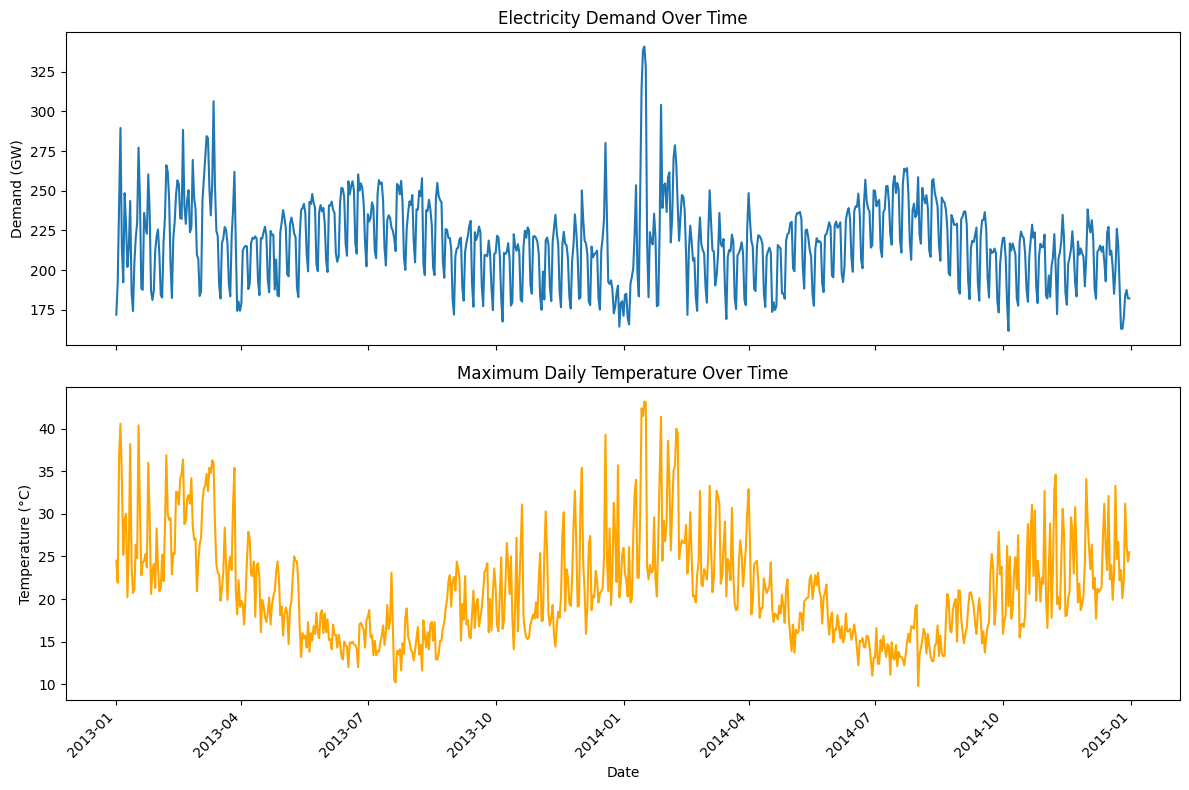

In [3]:
#데이터 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(vic_elec_daily['Demand'], label='Demand')
ax1.set_ylabel('Demand (GW)')
ax1.set_title('Electricity Demand Over Time')

ax2.plot(vic_elec_daily['Temperature'], label='Temperature', color='orange')
ax2.set_ylabel('Temperature (°C)')
ax2.set_title('Maximum Daily Temperature Over Time')

ax2.set_xlabel('Date')

plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()

plt.show()

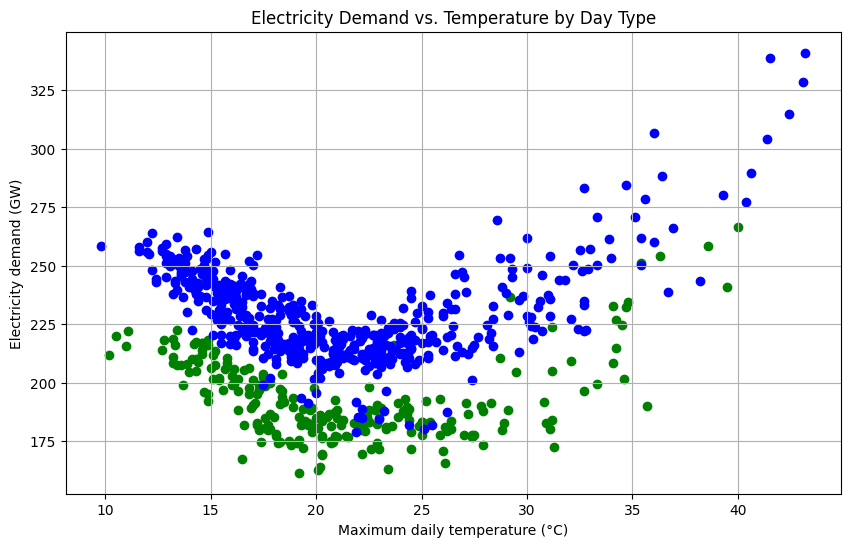

In [4]:
#외생 변수 영향 분석
plt.figure(figsize=(10, 6))
plt.scatter(vic_elec_daily[vic_elec_daily["Day_Type"] != 'Weekday']["Temperature"], vic_elec_daily[vic_elec_daily["Day_Type"] != 'Weekday']["Demand"], color="g", label="Playday")
plt.scatter(vic_elec_daily[vic_elec_daily["Day_Type"] == 'Weekday']["Temperature"], vic_elec_daily[vic_elec_daily["Day_Type"] == 'Weekday']["Demand"], color="b", label="Weekday")

plt.xlabel('Maximum daily temperature (°C)')
plt.ylabel('Electricity demand (GW)')
plt.title('Electricity Demand vs. Temperature by Day Type')

plt.grid(True)
plt.show()

### 3) 정상성 확인

In [5]:
#Adfuller test
print(adfuller(vic_elec_daily["Demand"][:-9])[1])

0.039268117380821865


### 4) 최적의 SARIMA(p, d, q), (P, D, Q, S) 모델 선택

In [6]:
#이차항 생성
X = pd.DataFrame()
X['Temperature'] = vic_elec_daily['Temperature']
X["Temperature^2"] = vic_elec_daily["Temperature"] ** 2
X["Weekday"] = (vic_elec_daily['Day_Type'] == 'Weekday').astype(int)

In [7]:
#SARIMA 파라미터 최적화 함수
def SARIMAX_optimizer(y, X):
    result= []
    for p in range(4):
        for q in range(4):
            for P in range(6):
                for Q in range(6-P):
                    try:
                        model = SARIMAX(y, X, order=(p, 1, q), simple_differencing=False, seasonal_order=(P, 0, Q, 7)).fit(dips=False)
                    except:
                        continue

                    aic = model.aic
                    result.append([p, q, P, Q, aic])

    result_df = pd.DataFrame(result)
    result_df.columns = ['p', 'q', 'P', 'Q', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [8]:
#오차 차수 최적화하기
result = SARIMAX_optimizer(vic_elec_daily["Demand"][:-9], X[:-9])
result

,p,q,P,Q,AIC
0,3,2,2,2,4807.224904
1,2,2,2,2,4807.863999
2,1,2,1,1,4807.869813
3,1,2,1,3,4809.010218
4,1,1,2,2,4809.996696
...,...,...,...,...,...
331,3,0,0,0,4979.238612
332,1,0,0,0,4983.134128
333,0,0,1,0,4996.440670
334,0,0,0,1,5010.175859


### 5) 모델 적합 결과

In [9]:
#실제 모델 적합
model = SARIMAX(vic_elec_daily["Demand"][:-9], exog=X[:-9], order=(3, 0, 2), simple_differencing=False, seasonal_order=(2, 0, 2, 7))
fit = model.fit(disp=False)
print(fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Demand   No. Observations:                  721
Model:             SARIMAX(3, 0, 2)x(2, 0, 2, 7)   Log Likelihood               -2474.054
Date:                           Mon, 30 Dec 2024   AIC                           4974.109
Time:                                   18:23:57   BIC                           5033.657
Sample:                               01-01-2013   HQIC                          4997.096
                                    - 12-22-2014                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Temperature      -7.7350      0.375    -20.654      0.000      -8.469      -7.001
Temperature^2     0.1787      0.00

### 6) 모델 적합성 검증

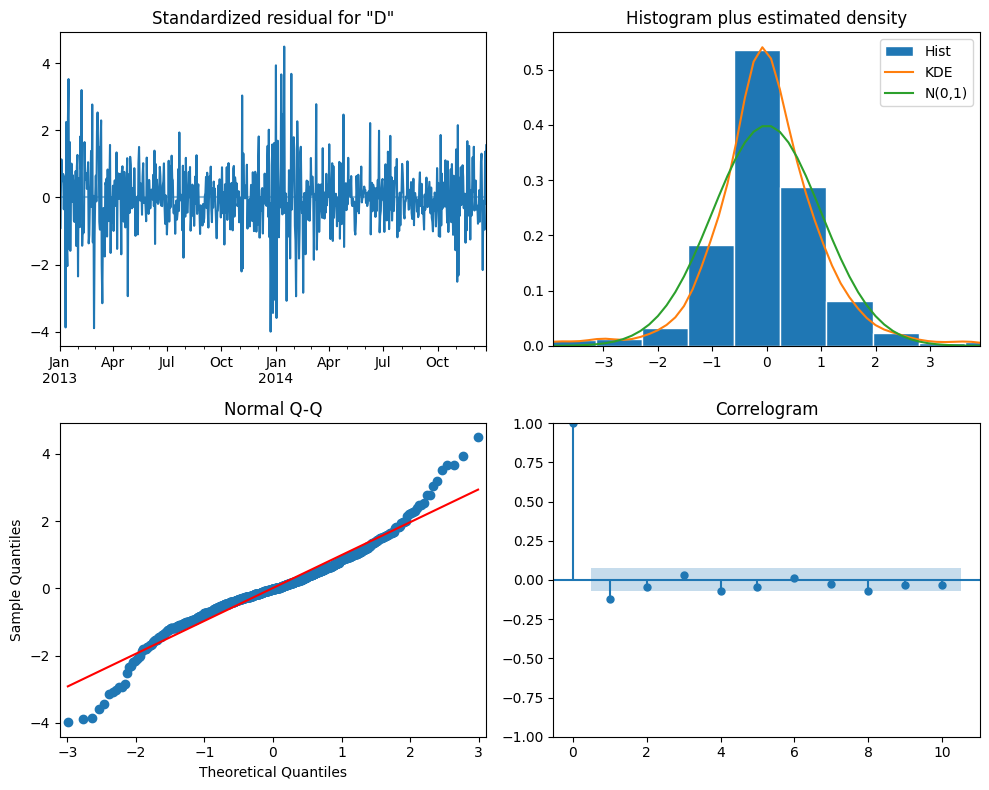

In [10]:
#잔차 확인
fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

### 7) 모델을 이용한 예측

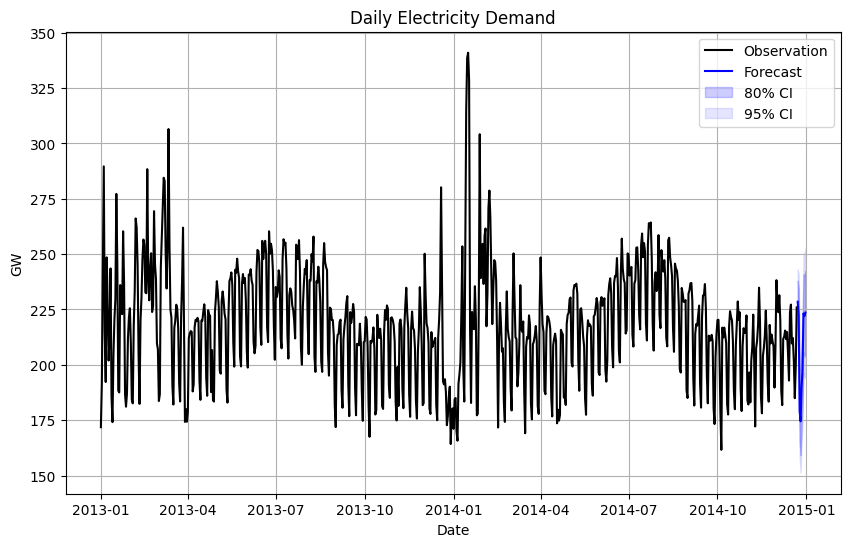

In [11]:
#SARIMAX 예측값 구하기기
forecast_result = fit.get_forecast(steps=9, exog=X[-9:])
forecast_mean = forecast_result.predicted_mean
lower_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 0]
upper_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 1]
lower_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 0]
upper_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 1]

#예측 시각화화
plt.figure(figsize=(10, 6))
plt.plot(vic_elec_daily['Demand'][:-9], label='Observation', color='black')
plt.plot(forecast_mean, label='Forecast', color='b')
plt.fill_between(forecast_mean.index, lower_ci80, upper_ci80, label='80% CI', color='b', alpha=.2)
plt.fill_between(forecast_mean.index, lower_ci95, upper_ci95, label='95% CI', color='b', alpha=.1)
plt.xlabel('Date')
plt.ylabel('GW')
plt.title('Daily Electricity Demand')
plt.grid(True)
plt.legend()
plt.show()

# 4.3.3. VAR

## 가처분 소득 변화와 실질 소비 변화에 대한 VAR 예측

### 1) 모듈과 데이터 불러오기

In [29]:
#모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests

import warnings
warnings.filterwarnings('ignore')

In [14]:
#데이터 불러오기
macro_econ_data = sm.datasets.macrodata.load_pandas().data
dpi_cons_quarter = macro_econ_data[['realdpi', 'realcons']]
dpi_cons_quarter.index = pd.date_range(start='1959/01/01', end='2009/09/30', freq='3MS')
dpi_cons_quarter

,realdpi,realcons
1959-01-01,1886.9,1707.4
1959-04-01,1919.7,1733.7
1959-07-01,1916.4,1751.8
1959-10-01,1931.3,1753.7
1960-01-01,1955.5,1770.5
...,...,...
2008-07-01,9838.3,9267.7
2008-10-01,9920.4,9195.3
2009-01-01,9926.4,9209.2
2009-04-01,10077.5,9189.0


### 2) 차분화된 가처분 소득과 실질 소비 시각화

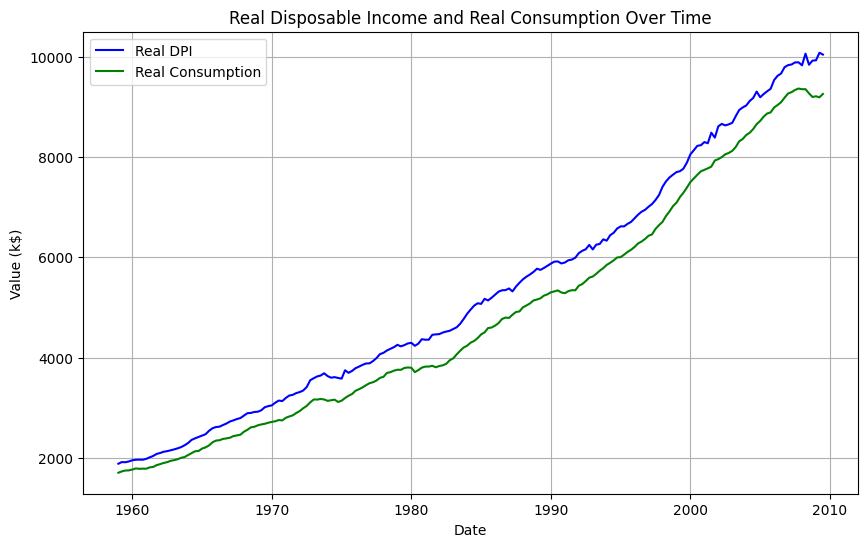

In [17]:
#데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(dpi_cons_quarter['realdpi'],  color='b', label='Real DPI')
plt.plot(dpi_cons_quarter['realcons'],  color='g', label='Real Consumption')
plt.xlabel("Date")
plt.ylabel("Value (k$)")
plt.title("Real Disposable Income and Real Consumption Over Time")
plt.grid(True)
plt.legend()
plt.show()

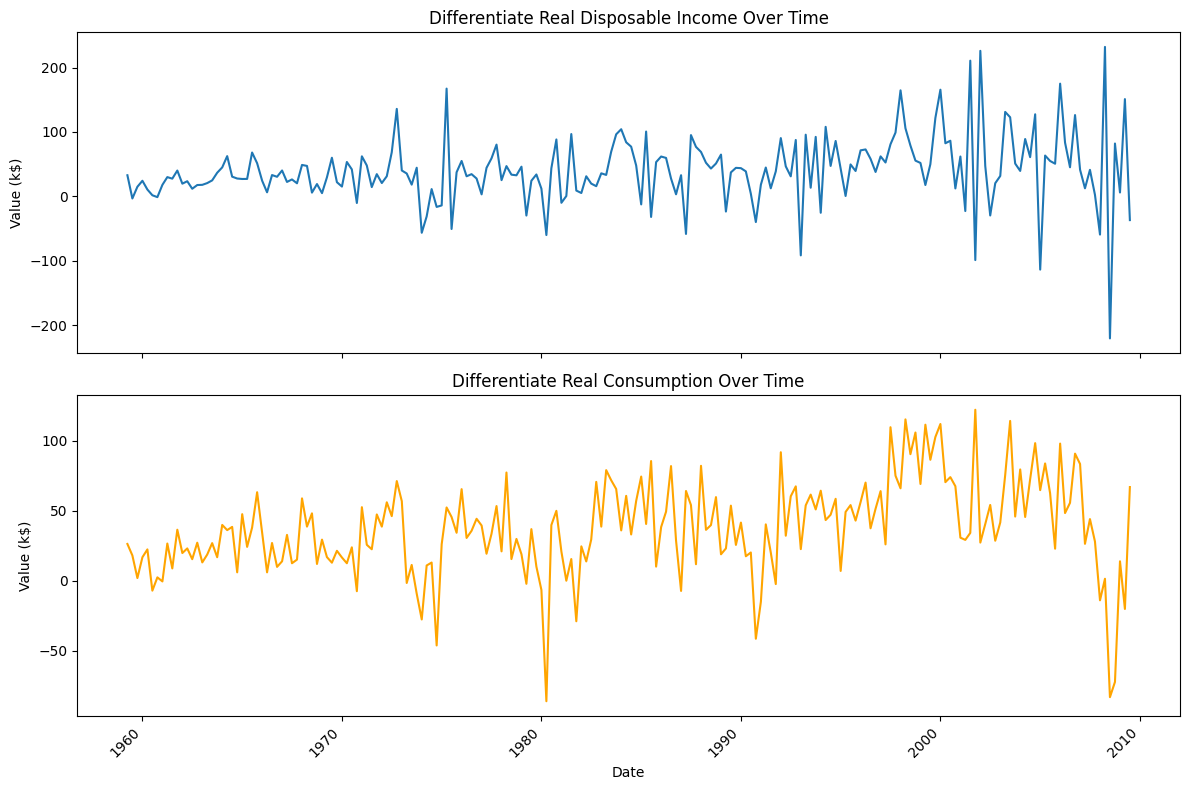

In [18]:
#1차 차분화 데이터 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(dpi_cons_quarter['realdpi'].diff()[1:], label='Real DPI')
ax1.set_ylabel('Value (k$)')
ax1.set_title('Differentiate Real Disposable Income Over Time')

ax2.plot(dpi_cons_quarter['realcons'].diff()[1:], label='Real Consumption', color='orange')
ax2.set_ylabel('Value (k$)')
ax2.set_title('Differentiate Real Consumption Over Time')

ax2.set_xlabel('Date')

plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()

### 3) 정상성 확인

In [21]:
#Adfuller test
print(adfuller(dpi_cons_quarter['realdpi'].diff()[1:][:180])[1])
print(adfuller(dpi_cons_quarter['realcons'].diff()[1:][:180])[1])

1.1698513528678687e-11
0.005911782900179311


### 4) 최적의 VAR(p) 모델 선택

In [23]:
#VAR 파라미터 최적화 함수
def VAR_optimizer(series):
    result= []
    for p in range(10):
        try:
            model = VARMAX(series, order=(p, 0)).fit(dips=False)
        except:
            continue

        aic = model.aic
        result.append([p, aic])

    result_df = pd.DataFrame(result)
    result_df.columns = ['p', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [24]:
#VAR 파라미터 최적화하기
result = VAR_optimizer(dpi_cons_quarter.diff()[1:][:180])
result

,p,AIC
0,3,3527.479734
1,6,3529.923785
2,4,3531.649739
3,5,3531.862367
4,8,3535.353965
5,7,3536.462469
6,2,3538.155109
7,9,3538.887452
8,1,3540.649008


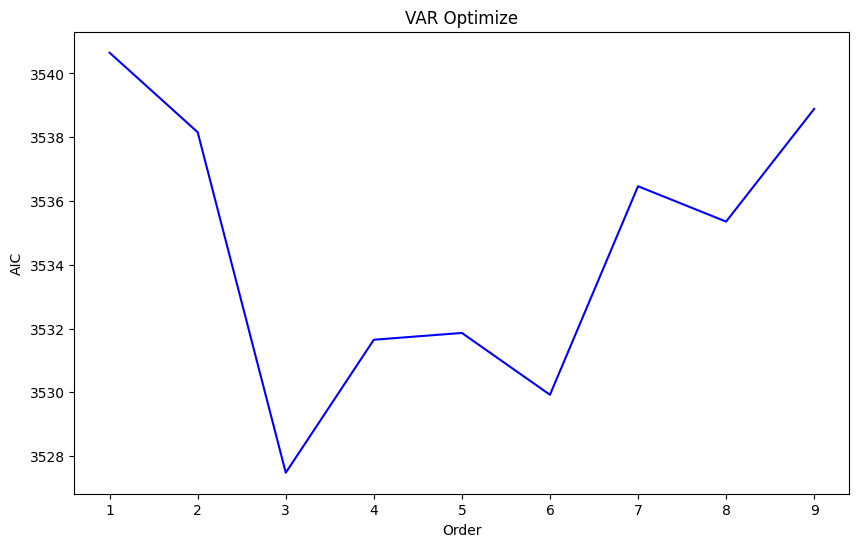

In [28]:
#VAR 최적화 시각화하기
result = result.sort_values(by='p', ascending=True).reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.plot(result['p'], result['AIC'], color='b', )
plt.xlabel("Order")
plt.ylabel("AIC")
plt.title("VAR Optimize")
plt.show()

### 5) 그레인저 인과관계 테스트

In [30]:
print(grangercausalitytests(dpi_cons_quarter[['realdpi', 'realcons']].diff()[1:][:180], [3]))
print(grangercausalitytests(dpi_cons_quarter[['realcons', 'realdpi']].diff()[1:][:180], [3]))


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12.9621 , p=0.0000  , df_denom=170, df_num=3
ssr based chi2 test:   chi2=40.4875 , p=0.0000  , df=3
likelihood ratio test: chi2=36.4605 , p=0.0000  , df=3
parameter F test:         F=12.9621 , p=0.0000  , df_denom=170, df_num=3
{np.int64(3): ({'ssr_ftest': (np.float64(12.962109059489094), np.float64(1.1494011565389888e-07), np.float64(170.0), np.int64(3)), 'ssr_chi2test': (np.float64(40.487528885815934), np.float64(8.398472694334837e-09), np.int64(3)), 'lrtest': (np.float64(36.46054468033162), np.float64(5.984129087710511e-08), np.int64(3)), 'params_ftest': (np.float64(12.962109059489125), np.float64(1.149401156538946e-07), np.float64(170.0), 3.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002621D565A90>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026218E02790>, array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       

### 6) 모델 적합 결과

In [37]:
#실제 모델 적합
model = VARMAX(dpi_cons_quarter.diff()[1:][:180], order=(3, 0))
fit = model.fit()
print(fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  180
Model:                              VAR(3)   Log Likelihood               -1746.740
                               + intercept   AIC                           3527.480
Date:                     Mon, 30 Dec 2024   BIC                           3581.760
Time:                             20:10:16   HQIC                          3549.488
Sample:                         04-01-1959                                         
                              - 01-01-2004                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.06, 0.00   Jarque-Bera (JB):         31.88, 10.85
Prob(Q):                        0.80, 0.96   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         4.52, 2.45   Skew:                      0.38

### 7) 모델 적합성 검증

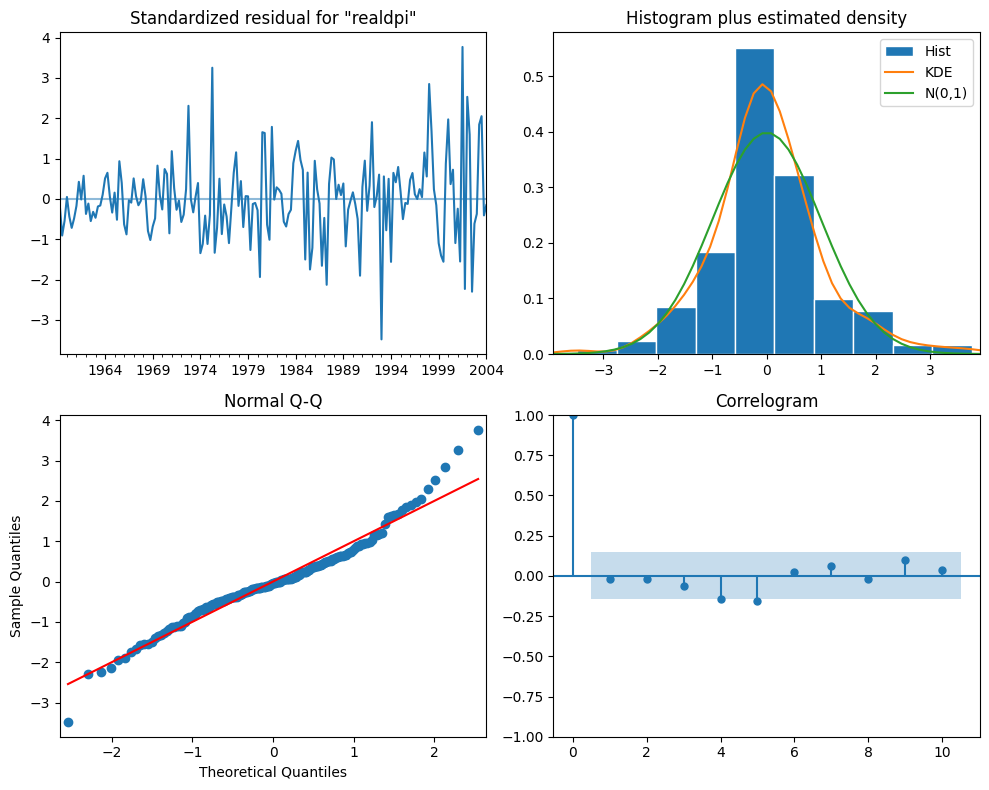

In [38]:
#가처분 소득 모델 잔차 확인
fit.plot_diagnostics(figsize=(10,8), variable=0)
plt.tight_layout()
plt.show()

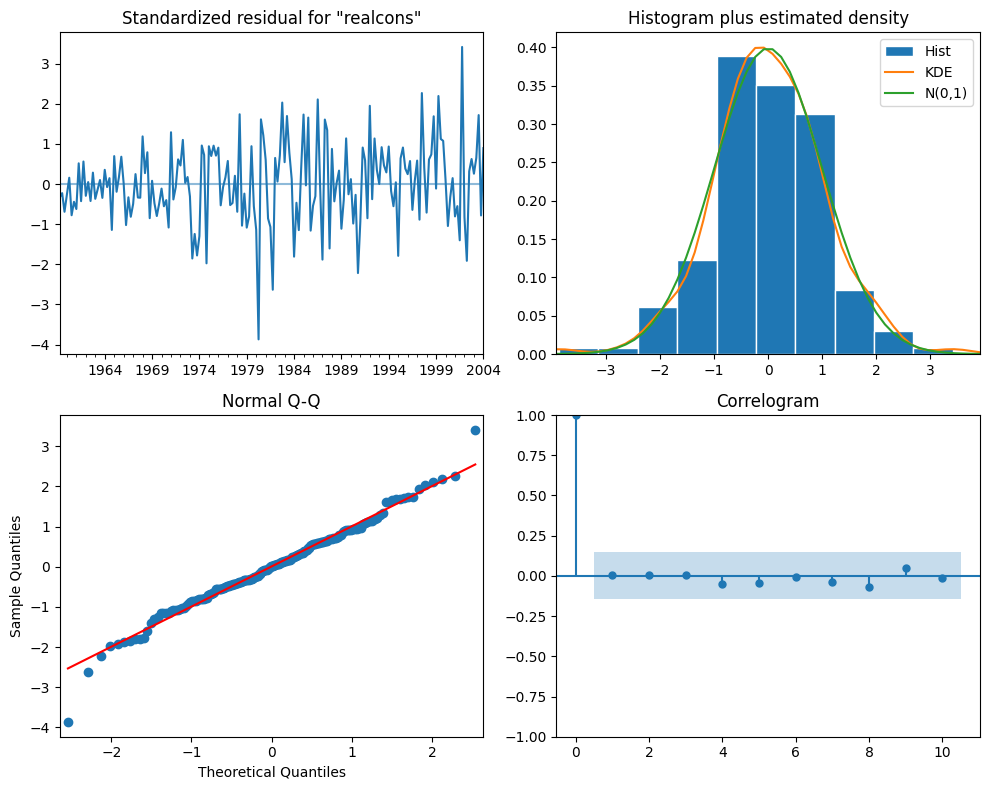

In [39]:
#실질 소비 모델 잔차 확인
fit.plot_diagnostics(figsize=(10,8), variable=1)
plt.tight_layout()
plt.show()

### 8) 모델을 이용한 예측

In [54]:
#VAR 예측값 구하기기
forecast_result = fit.get_forecast(steps=22)

forecast_mean = forecast_result.predicted_mean
cum_forecast_result = forecast_mean.cumsum()
cum_forecast_result['realdpi'] = cum_forecast_result['realdpi'] + dpi_cons_quarter.iloc[179, 0]
cum_forecast_result['realcons'] = cum_forecast_result['realcons'] + dpi_cons_quarter.iloc[179, 1]

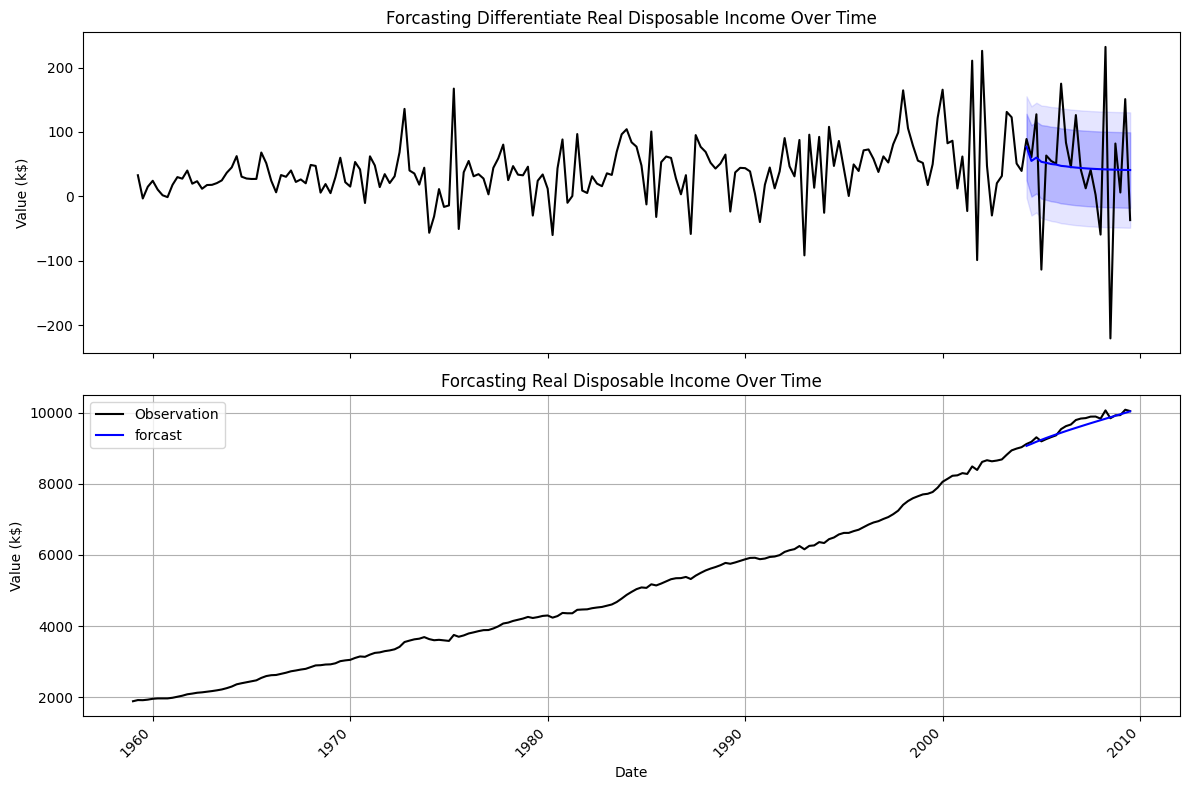

In [57]:
#가처분 소득 신뢰구간
lower_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 0]
upper_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 2]
lower_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 0]
upper_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 2]

#예측 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(dpi_cons_quarter['realdpi'].diff()[1:], label='Observation', color='black')
ax1.plot(forecast_mean['realdpi'], label='forcast', color='b')
ax1.fill_between(forecast_mean.index, lower_ci80, upper_ci80, label='80% CI', color='b', alpha=.2)
ax1.fill_between(forecast_mean.index, lower_ci95, upper_ci95, label='95% CI', color='b', alpha=.1)
ax1.set_ylabel('Value (k$)')
ax1.set_title('Forcasting Differentiate Real Disposable Income Over Time')

ax2.plot(dpi_cons_quarter['realdpi'], label='Observation', color='black')
ax2.plot(cum_forecast_result['realdpi'], label='forcast', color='b')
ax2.set_ylabel('Value (k$)')
ax2.set_title('Forcasting Real Disposable Income Over Time')

ax2.set_xlabel('Date')

plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()

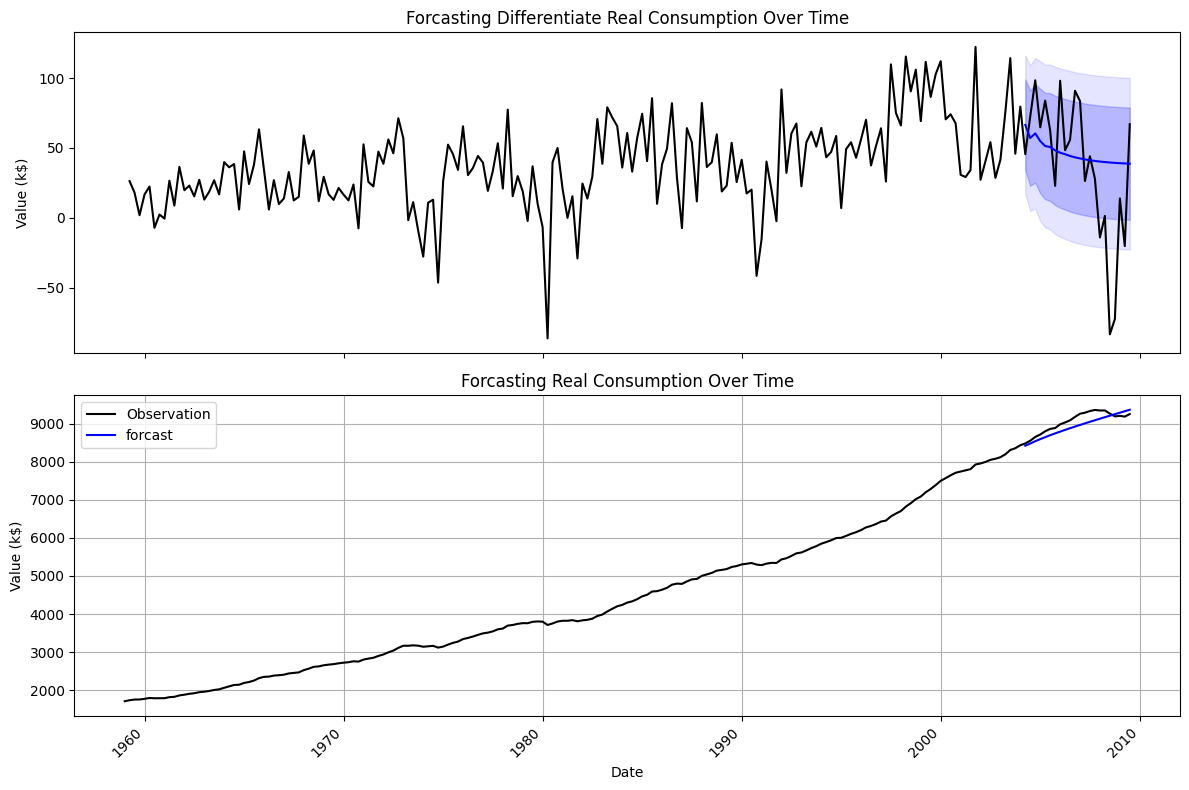

In [59]:
#실질소비 소득 신뢰구간
lower_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 1]
upper_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 3]
lower_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 1]
upper_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 3]

#예측 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(dpi_cons_quarter['realcons'].diff()[1:], label='Observation', color='black')
ax1.plot(forecast_mean['realcons'], label='forcast', color='b')
ax1.fill_between(forecast_mean.index, lower_ci80, upper_ci80, label='80% CI', color='b', alpha=.2)
ax1.fill_between(forecast_mean.index, lower_ci95, upper_ci95, label='95% CI', color='b', alpha=.1)
ax1.set_ylabel('Value (k$)')
ax1.set_title('Forcasting Differentiate Real Consumption Over Time')

ax2.plot(dpi_cons_quarter['realcons'], label='Observation', color='black')
ax2.plot(cum_forecast_result['realcons'], label='forcast', color='b')
ax2.set_ylabel('Value (k$)')
ax2.set_title('Forcasting Real Consumption Over Time')

ax2.set_xlabel('Date')

plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()